In [314]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn import preprocessing
from sklearn import svm, tree
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import StratifiedShuffleSplit
%matplotlib inline

pd.options.display.max_columns = 999
sns.set_palette(sns.cubehelix_palette(1))
# sns.set_palette(sns.color_palette('coolwarm'))


In [331]:
def get_data():
    columns = ["checking_ac", "duration", "credit_history", "purpose", "amount", "saving_ac",
           "employment_status", "installment_rate", 'personal_status_sex', "debtor_guarantor", "residence_since",
          "property", "age", "installment_plan", "housing", "existing_credits", "job", "liable_count", "telephone",
          "foreign_worker", "target"]
    df = pd.read_csv("../data/german.data2.csv", delimiter=' ', index_col=False, names=columns)
    
    return df

def get_columns(df):
    cat_cols = []
    for col in df.columns:
        if len(df[col].unique()) < 11:
            cat_cols.append(col)
            df[col]=df[col].astype('category')

def dist_plot(df, col_name):
    plt.title(i)
    sns.distplot(df[col_name])
    plt.show()
    
def count_plot(df, col_name):
    plt.title(i)
    sns.countplot(df[col_name])
    plt.show()
    
def count_cat_plot(df, col_name):
    sns.countplot(x=col_name, hue="target", data=df, dodge=False)
    plt.show()

def qq_plot(df, col_name):
    stats.probplot(df[col_name], dist="norm", plot=plt)
    plt.title(col_name)
    plt.show()
    
def box_plot(df, col_name):
    sns.boxplot(df[col_name])
    plt.title(col_name)
    plt.show()
    
def facet_plot(df, row, col, over):
    g = sns.FacetGrid(df, col=col, row=row)
    g_map = g.map(plt.hist, over)
    
def pair_plot(df):
    sns.pairplot(df)
    
def heatmap(df):
    sns.heatmap(df.corr())
    
def left_skew_removal(df, col_name):
    df[col_name] = np.sqrt(df[col_name])
    return df[col_name]

def right_skew_removal(df, col_name):
    df[col_name] = np.log(df[col_name])
    return df[col_name]

def remove_outlier(df, col_name):

    q75, q25 = np.percentile(df[col_name], [75 ,25])
    iqr = q75 - q25
    min_v = q25 - (iqr*1.5)
    max_v = q75 + (iqr*1.5)

    for indx, val in df[col_name].iteritems():
        if val < min_v:
            df[col_name][indx] = min_v
        elif val > max_v:
            df[col_name][indx] = max_v
            
    plt.subplot('211')
    dist_plot(df, col_name)
    plt.subplot('212')
    box_plot(df, col_name)
    plt.show()
    
def plot_features(X_train, X_test, y_train, y_test, model):
    accuracies = []
    features = []
    plt.figure(figsize=(15,15))
    for idx, feature in enumerate(X_train.columns):
        model = model
        model.fit(pd.DataFrame(X_train[feature]), y_train.values.ravel())
        y_pred = model.predict(pd.DataFrame(X_test[feature]))
        acc = accuracy_score(y_pred=y_pred, y_true=y_test)
        accuracies.append(acc)
        features.append(feature)

    features = [x for x in sorted(zip(accuracies,features))]
    accuracies = sorted(accuracies)
    plt.title('Feature Importances')
    plt.barh(range(len(accuracies)), accuracies, color='b', align='center')
    plt.yticks(range(len(features)), features)
    plt.xlabel('Relative Importance')
    plt.show()
    
def plot_features_clf(clf):
    features = X_train.columns
    importances = clf.feature_importances_
    indices = np.argsort(importances)

    fig_size = plt.rcParams["figure.figsize"]
    fig_size[0] = 9
    fig_size[1] = 12
    plt.rcParams["figure.figsize"] = fig_size
    plt.title('Feature Importances')
    plt.barh(range(len(indices)), importances[indices], color='b', align='center')
    plt.yticks(range(len(indices)), features[indices])
    plt.xlabel('Relative Importance')
    plt.show()

In [316]:
df = get_data()

In [317]:
X_train, X_test, y_train, y_test = train_test_split(df.iloc[:, :-1], df.iloc[:, 20:21], test_size=0.2, random_state=3)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=3)

In [318]:
print("X Train: " + str(X_train.shape))
print("Y Train: " + str(y_train.shape))

print("X Test: " + str(X_test.shape))
print("Y Test: " + str(y_test.shape))

print("X Val: " + str(X_val.shape))
print("Y Val: " + str(y_val.shape))

X Train: (640, 20)
Y Train: (640, 1)
X Test: (200, 20)
Y Test: (200, 1)
X Val: (160, 20)
Y Val: (160, 1)


In [319]:
cat_dict = {
    "A11": "-0",
    "A12": "0-200",
    "A13": "200+",
    "A14": "no checking acc",
    "A31": "no credit",
    "A32": "paid duly",
    "A33": "delay",
    "A34": "critical acc",
    "A40": "car (new)",
    "A41": "car (old)",
    "A42": "furniture/equipment",
    "A43": "radio/television",
    "A44": "domestic appliances",
    "A45": "repairs",
    "A46": "education",
    "A47": "vacation",
    "A48": "retraining",
    "A49": "business",
    "A410": "others",
    "A61": "-100",
    "A62": "100-500",
    "A63": "500-1000",
    "A64": "1000+",
    "A65": "no acc",
    "A71": "unemployed",
    "A72": "-1",
    "A73": "1-4",
    "A74": "4-7",
    "A75": "7+",
    "A91": "male-div/sep",
    "A92": "male-single",
    "A93": "male-married",
    "A94": "female-div/sep/mar",
    "A95": "female-single",
    "A101": "none",
    "A102": "co-applicant",
    "A103": "guarantor",
    "A121": "real est",
    "A122": "building",
    "A123": "car",
    "A124": "none",
    "A141": "bank",
    "A142": "store",
    "A143": "none",
    "A151": "rent",
    "A152": "own",
    "A153": "free",
    "A171": "unempl-no res",
    "A172": "unempl-res",
    "A173": "empl",
    "A174": "high empl",
    "A191": "yes",
    "A191": "no",
    "A201": "yes",
    "A201": "no",
}
df.replace(cat_dict, inplace=True)
df.target.replace({2: 0}, inplace=True)

In [320]:
df.head()

,checking_ac,duration,credit_history,purpose,amount,saving_ac,employment_status,installment_rate,personal_status_sex,debtor_guarantor,residence_since,property,age,installment_plan,housing,existing_credits,job,liable_count,telephone,foreign_worker,target
0,-0,6,critical acc,radio/television,1169,no acc,7+,4,male-married,none,4,real est,67,none,own,2,empl,1,A192,no,1
1,0-200,48,paid duly,radio/television,5951,-100,1-4,2,male-single,none,2,real est,22,none,own,1,empl,1,no,no,0
2,no checking acc,12,critical acc,education,2096,-100,4-7,2,male-married,none,3,real est,49,none,own,1,unempl-res,2,no,no,1
3,-0,42,paid duly,furniture/equipment,7882,-100,4-7,2,male-married,guarantor,4,building,45,none,free,1,empl,2,no,no,1
4,-0,24,delay,car (new),4870,-100,1-4,3,male-married,none,4,none,53,none,free,2,empl,2,no,no,0


In [321]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 21 columns):
checking_ac            1000 non-null object
duration               1000 non-null int64
credit_history         1000 non-null object
purpose                1000 non-null object
amount                 1000 non-null int64
saving_ac              1000 non-null object
employment_status      1000 non-null object
installment_rate       1000 non-null int64
personal_status_sex    1000 non-null object
debtor_guarantor       1000 non-null object
residence_since        1000 non-null int64
property               1000 non-null object
age                    1000 non-null int64
installment_plan       1000 non-null object
housing                1000 non-null object
existing_credits       1000 non-null int64
job                    1000 non-null object
liable_count           1000 non-null int64
telephone              1000 non-null object
foreign_worker         1000 non-null object
target               

In [322]:
df.describe()

,duration,amount,installment_rate,residence_since,age,existing_credits,liable_count,target
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,20.903000,3271.258000,2.973000,2.845000,35.546000,1.407000,1.155000,0.700000
std,12.058814,2822.736876,1.118715,1.103718,11.375469,0.577654,0.362086,0.458487
min,4.000000,250.000000,1.000000,1.000000,19.000000,1.000000,1.000000,0.000000
25%,12.000000,1365.500000,2.000000,2.000000,27.000000,1.000000,1.000000,0.000000
50%,18.000000,2319.500000,3.000000,3.000000,33.000000,1.000000,1.000000,1.000000
75%,24.000000,3972.250000,4.000000,4.000000,42.000000,2.000000,1.000000,1.000000
max,72.000000,18424.000000,4.000000,4.000000,75.000000,4.000000,2.000000,1.000000


In [230]:
num_cols = list(df.describe().columns)
cat_cols = list(set(df.columns) - set(num_cols))
print(num_cols, cat_cols)

['duration', 'amount', 'installment_rate', 'residence_since', 'age', 'existing_credits', 'liable_count', 'target'] ['checking_ac', 'employment_status', 'housing', 'telephone', 'installment_plan', 'purpose', 'credit_history', 'property', 'personal_status_sex', 'job', 'foreign_worker', 'debtor_guarantor', 'saving_ac']


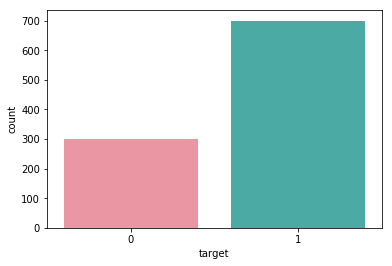

In [231]:
sns.countplot(x='target', data=df)

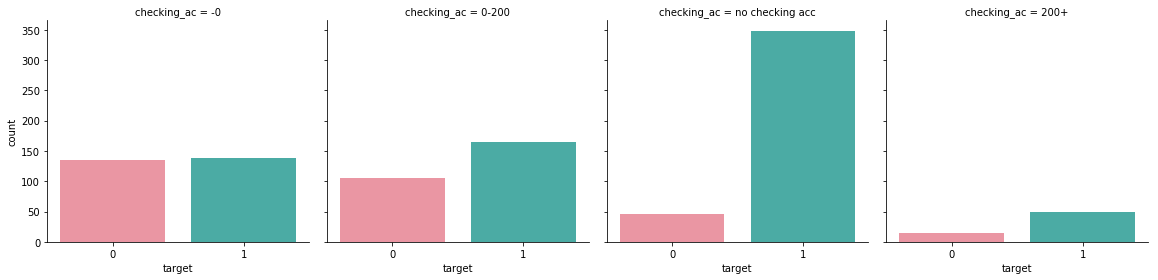

checking_ac      target
-0               0         135
                 1         139
0-200            0         105
                 1         164
200+             0          14
                 1          49
no checking acc  0          46
                 1         348
Name: target, dtype: int64


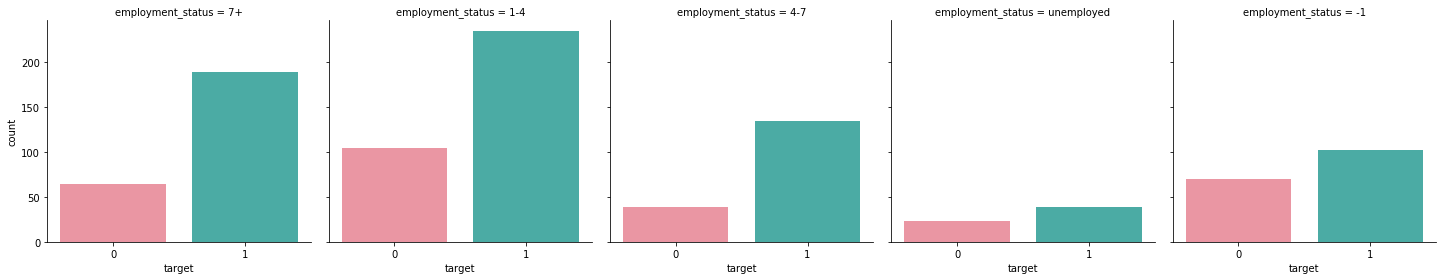

employment_status  target
-1                 0          70
                   1         102
1-4                0         104
                   1         235
4-7                0          39
                   1         135
7+                 0          64
                   1         189
unemployed         0          23
                   1          39
Name: target, dtype: int64


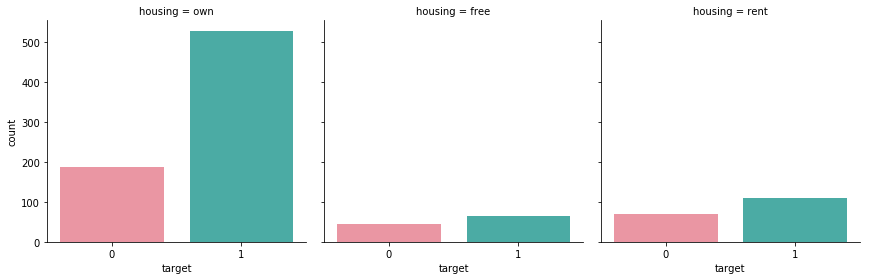

housing  target
free     0          44
         1          64
own      0         186
         1         527
rent     0          70
         1         109
Name: target, dtype: int64


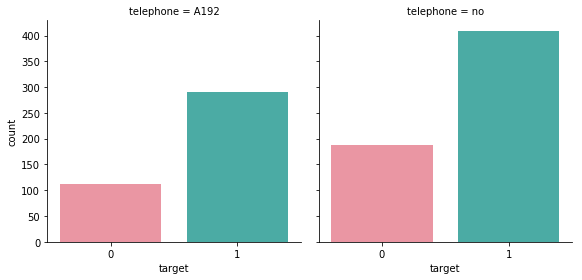

telephone  target
A192       0         113
           1         291
no         0         187
           1         409
Name: target, dtype: int64


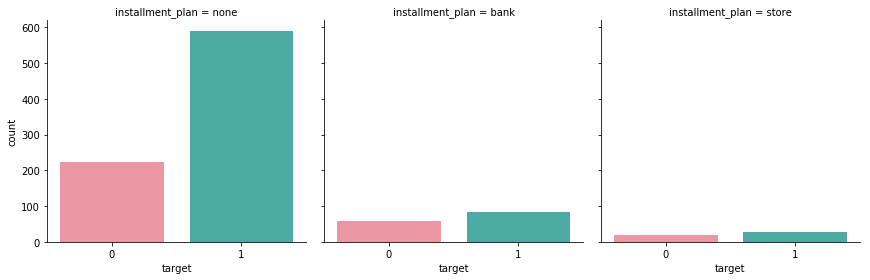

installment_plan  target
bank              0          57
                  1          82
none              0         224
                  1         590
store             0          19
                  1          28
Name: target, dtype: int64


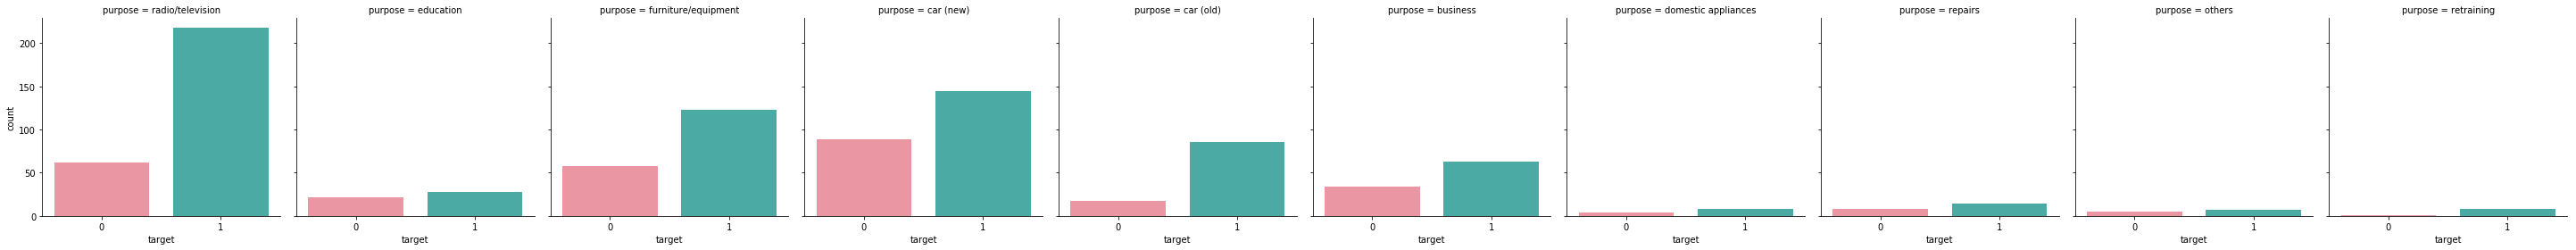

purpose              target
business             0          34
                     1          63
car (new)            0          89
                     1         145
car (old)            0          17
                     1          86
domestic appliances  0           4
                     1           8
education            0          22
                     1          28
furniture/equipment  0          58
                     1         123
others               0           5
                     1           7
radio/television     0          62
                     1         218
repairs              0           8
                     1          14
retraining           0           1
                     1           8
Name: target, dtype: int64


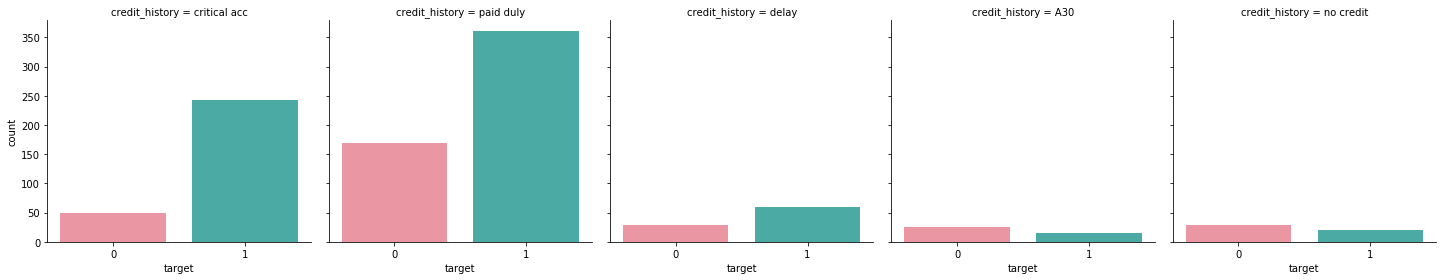

credit_history  target
A30             0          25
                1          15
critical acc    0          50
                1         243
delay           0          28
                1          60
no credit       0          28
                1          21
paid duly       0         169
                1         361
Name: target, dtype: int64


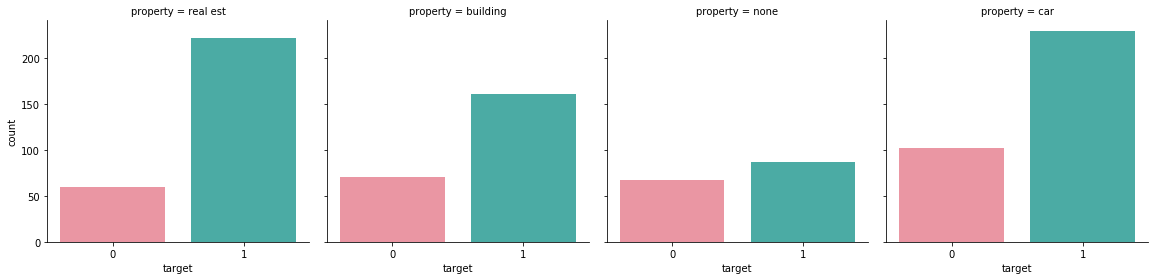

property  target
building  0          71
          1         161
car       0         102
          1         230
none      0          67
          1          87
real est  0          60
          1         222
Name: target, dtype: int64


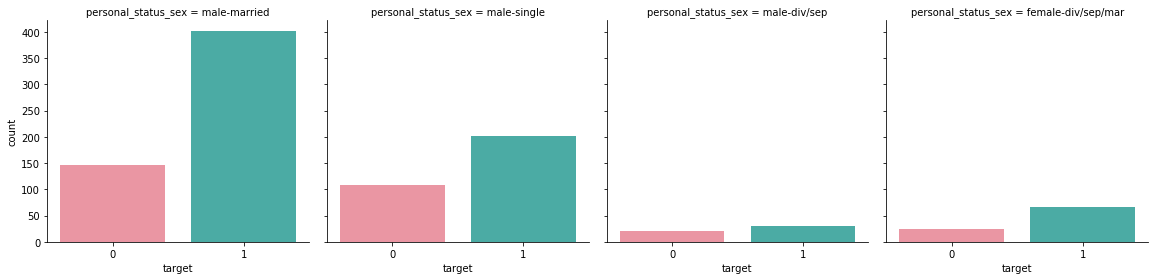

personal_status_sex  target
female-div/sep/mar   0          25
                     1          67
male-div/sep         0          20
                     1          30
male-married         0         146
                     1         402
male-single          0         109
                     1         201
Name: target, dtype: int64


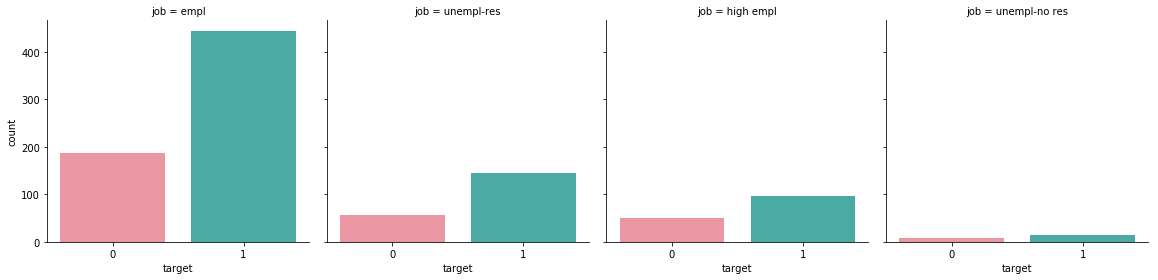

job            target
empl           0         186
               1         444
high empl      0          51
               1          97
unempl-no res  0           7
               1          15
unempl-res     0          56
               1         144
Name: target, dtype: int64


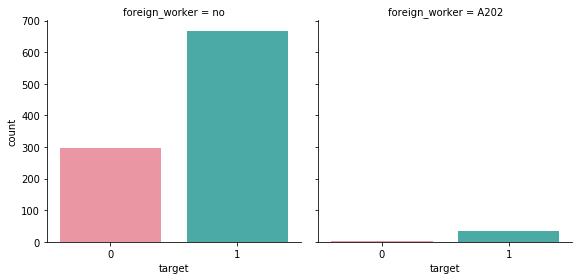

foreign_worker  target
A202            0           4
                1          33
no              0         296
                1         667
Name: target, dtype: int64


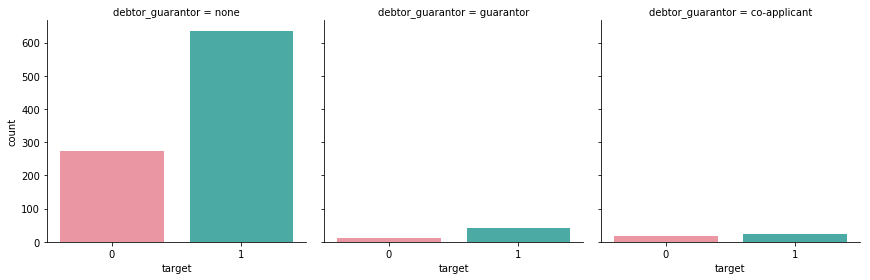

debtor_guarantor  target
co-applicant      0          18
                  1          23
guarantor         0          10
                  1          42
none              0         272
                  1         635
Name: target, dtype: int64


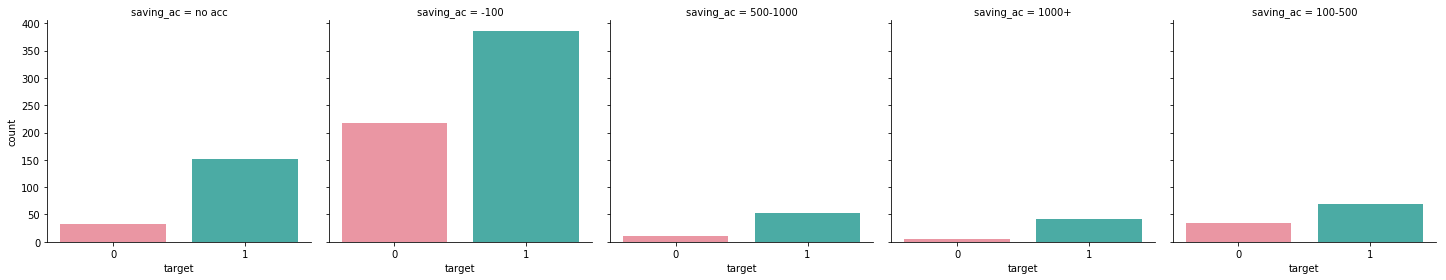

saving_ac  target
-100       0         217
           1         386
100-500    0          34
           1          69
1000+      0           6
           1          42
500-1000   0          11
           1          52
no acc     0          32
           1         151
Name: target, dtype: int64


In [232]:
for i in cat_cols:
    sns.factorplot(x='target', col=i, kind='count', data=df)
    plt.show()
    print(df.groupby([i, 'target']).target.count())

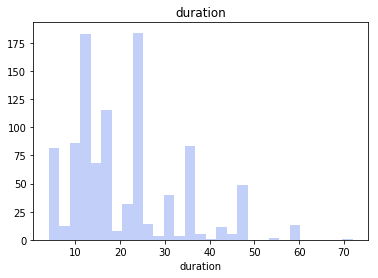

duration  target
4         1           6
5         1           1
6         0           9
          1          66
7         1           5
8         0           1
          1           6
9         0          14
          1          35
10        0           3
          1          25
11        1           9
12        0          49
          1         130
13        1           4
14        0           1
          1           3
15        0          12
          1          52
16        0           1
          1           1
18        0          42
          1          71
20        0           1
          1           7
21        0           9
          1          21
22        1           2
24        0          56
          1         128
26        1           1
27        0           5
          1           8
28        0           1
          1           2
30        0          13
          1          27
33        0           1
          1           2
36        0          37
          1          46

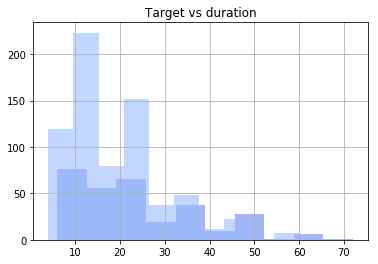

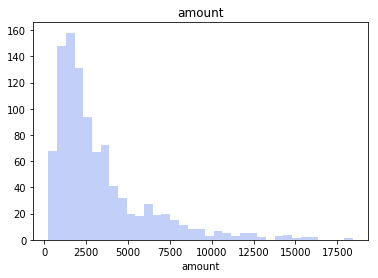

amount  target
250     1         1
276     1         1
338     1         1
339     1         1
343     1         1
362     1         1
368     1         1
385     1         1
392     1         1
409     1         1
426     1         1
428     1         1
433     0         2
448     0         1
454     1         1
458     1         1
484     1         1
518     1         1
522     1         1
571     1         1
585     1         1
590     1         1
601     1         1
609     0         1
        1         1
618     1         1
625     1         1
626     0         1
629     1         1
639     0         1
                 ..
10974   0         1
11054   1         1
11328   0         1
11560   0         1
11590   0         1
11760   1         1
11816   0         1
11938   0         1
11998   0         1
12169   1         1
12204   1         1
12389   0         1
12579   0         1
12612   0         1
12680   0         1
12749   1         1
12976   0         1
13756   1         1
14027

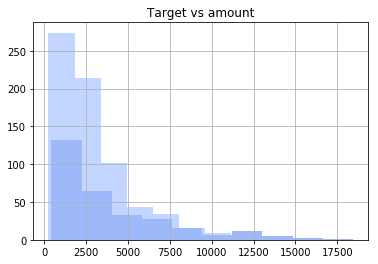

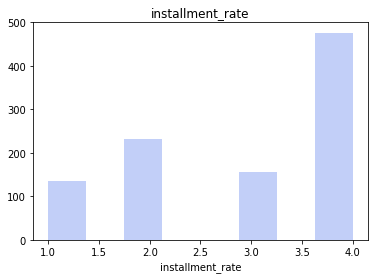

installment_rate  target
1                 0          34
                  1         102
2                 0          62
                  1         169
3                 0          45
                  1         112
4                 0         159
                  1         317
Name: target, dtype: int64


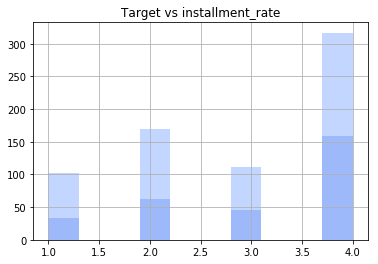

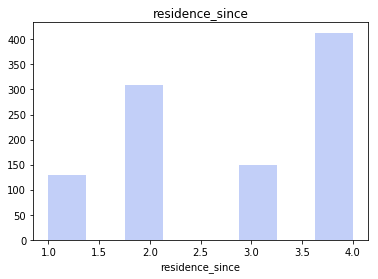

residence_since  target
1                0          36
                 1          94
2                0          97
                 1         211
3                0          43
                 1         106
4                0         124
                 1         289
Name: target, dtype: int64


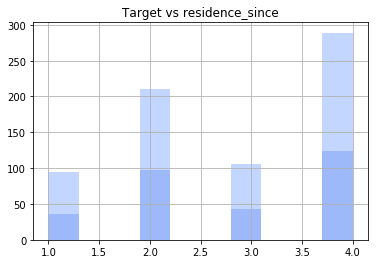

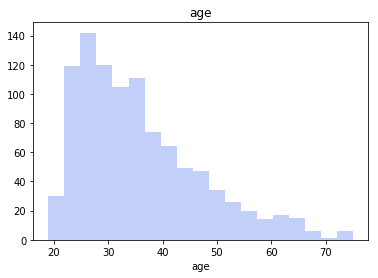

age  target
19   0          1
     1          1
20   0          5
     1          9
21   0          5
     1          9
22   0         11
     1         16
23   0         20
     1         28
24   0         19
     1         25
25   0         19
     1         22
26   0         14
     1         36
27   0         13
     1         38
28   0         15
     1         28
29   0         15
     1         22
30   0         11
     1         29
31   0         11
     1         27
32   0          9
     1         25
33   0         13
     1         20
               ..
54   0          2
     1          8
55   0          3
     1          5
56   1          3
57   0          3
     1          6
58   0          2
     1          3
59   0          1
     1          2
60   0          3
     1          3
61   0          3
     1          4
62   1          2
63   0          1
     1          7
64   1          5
65   0          1
     1          4
66   0          2
     1          3
67   1          

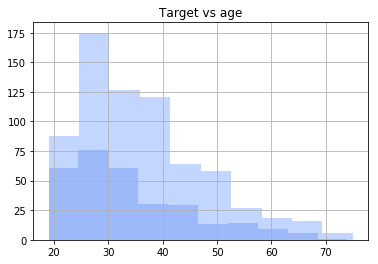

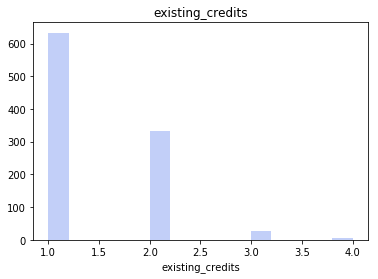

existing_credits  target
1                 0         200
                  1         433
2                 0          92
                  1         241
3                 0           6
                  1          22
4                 0           2
                  1           4
Name: target, dtype: int64


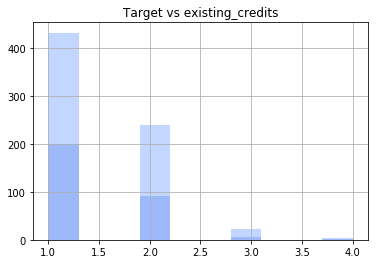

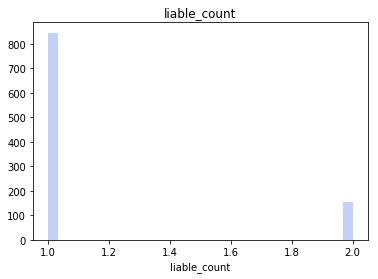

liable_count  target
1             0         254
              1         591
2             0          46
              1         109
Name: target, dtype: int64


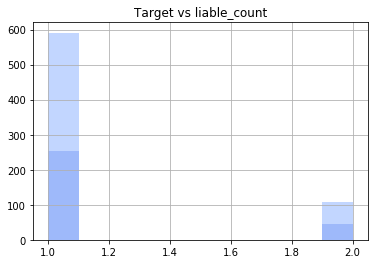

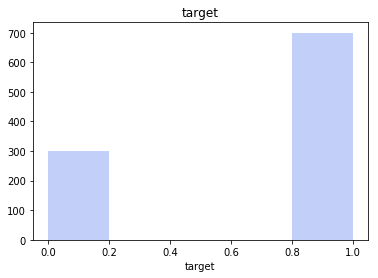

target  target
0       0         300
1       1         700
Name: target, dtype: int64


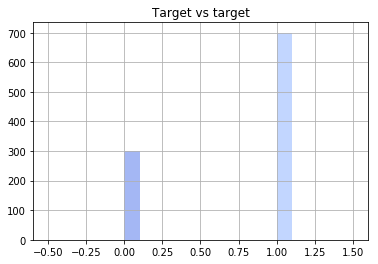

In [233]:
for i in num_cols:
    sns.set_palette(sns.color_palette('coolwarm'))
    plt.title(i)
    sns.distplot(df[i], kde=False)
    plt.show()
    plt.title("Target vs " + i)
    df.groupby('target')[i].hist(alpha=0.6)
    print(df.groupby([i, 'target'])['target'].count())
    plt.show()



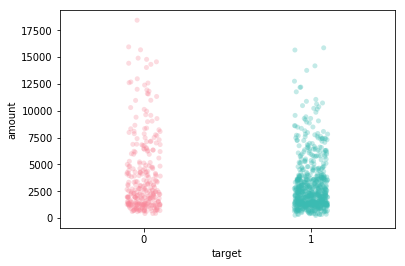

<function matplotlib.pyplot.show(*args, **kw)>

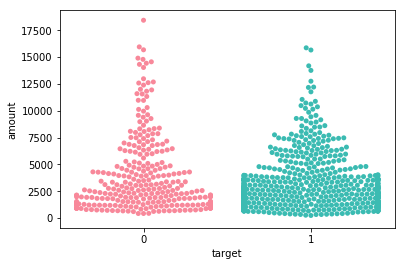

In [234]:
sns.set_palette(sns.cubehelix_palette(1))
sns.stripplot(x='target', y='amount', data=df, alpha=0.3, jitter=True);
plt.show()
sns.swarmplot(x='target', y='amount', data=df)
plt.show

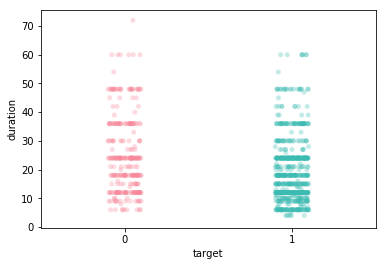

<function matplotlib.pyplot.show(*args, **kw)>

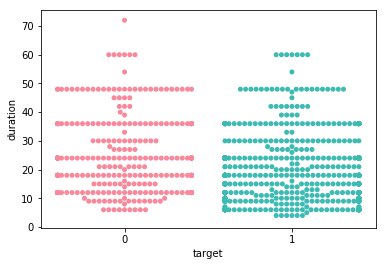

In [235]:
sns.set_palette(sns.cubehelix_palette(1))
sns.stripplot(x='target', y='duration', data=df, alpha=0.3, jitter=True);
plt.show()
sns.swarmplot(x='target', y='duration', data=df)
plt.show

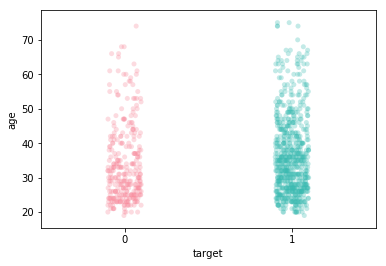

<function matplotlib.pyplot.show(*args, **kw)>

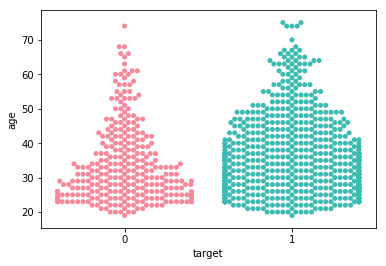

In [236]:
sns.set_palette(sns.cubehelix_palette(1))
sns.stripplot(x='target', y='age', data=df, alpha=0.3, jitter=True);
plt.show()
sns.swarmplot(x='target', y='age', data=df)
plt.show

/home/ubuntu/miniconda/envs/credit/lib/python3.6/site-packages/statsmodels/genmod/families/family.py:880: RuntimeWarning: divide by zero encountered in true_divide
  n_endog_mu = self._clean((1. - endog) / (1. - mu))


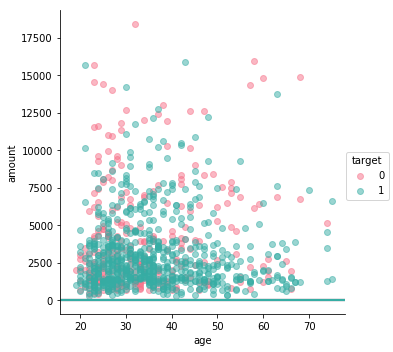

In [237]:
sns.set_palette(sns.cubehelix_palette(1))
sns.lmplot(x='age', y='amount', hue='target', data=df, logistic=True, scatter_kws={'alpha':0.5})

/home/ubuntu/miniconda/envs/credit/lib/python3.6/site-packages/statsmodels/genmod/families/family.py:880: RuntimeWarning: divide by zero encountered in true_divide
  n_endog_mu = self._clean((1. - endog) / (1. - mu))
/home/ubuntu/miniconda/envs/credit/lib/python3.6/site-packages/statsmodels/genmod/families/links.py:167: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)


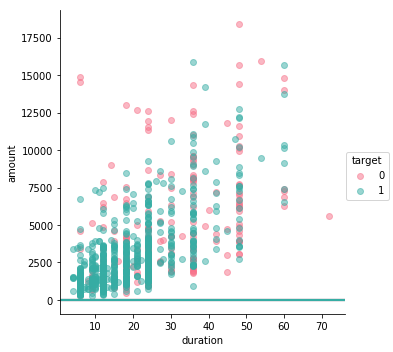

In [238]:
sns.set_palette(sns.cubehelix_palette(1))
sns.lmplot(x='duration', y='amount', hue='target', data=df, logistic=True, scatter_kws={'alpha':0.5})

/home/ubuntu/miniconda/envs/credit/lib/python3.6/site-packages/statsmodels/genmod/families/family.py:880: RuntimeWarning: divide by zero encountered in true_divide
  n_endog_mu = self._clean((1. - endog) / (1. - mu))


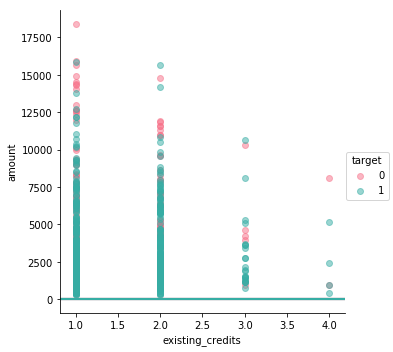

In [239]:
sns.set_palette(sns.cubehelix_palette(1))
sns.lmplot(x='existing_credits', y='amount', hue='target', data=df, logistic=True, scatter_kws={'alpha':0.5})

/home/ubuntu/miniconda/envs/credit/lib/python3.6/site-packages/statsmodels/genmod/families/family.py:880: RuntimeWarning: divide by zero encountered in true_divide
  n_endog_mu = self._clean((1. - endog) / (1. - mu))


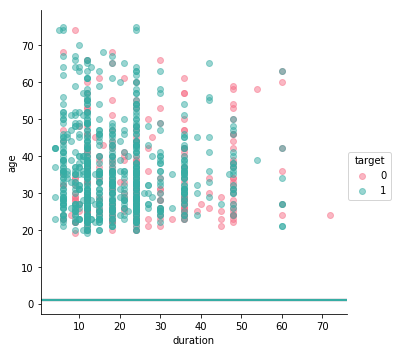

In [240]:
sns.set_palette(sns.cubehelix_palette(1))
sns.lmplot(x='duration', y='age', hue='target', data=df, logistic=True, scatter_kws={'alpha':0.5})

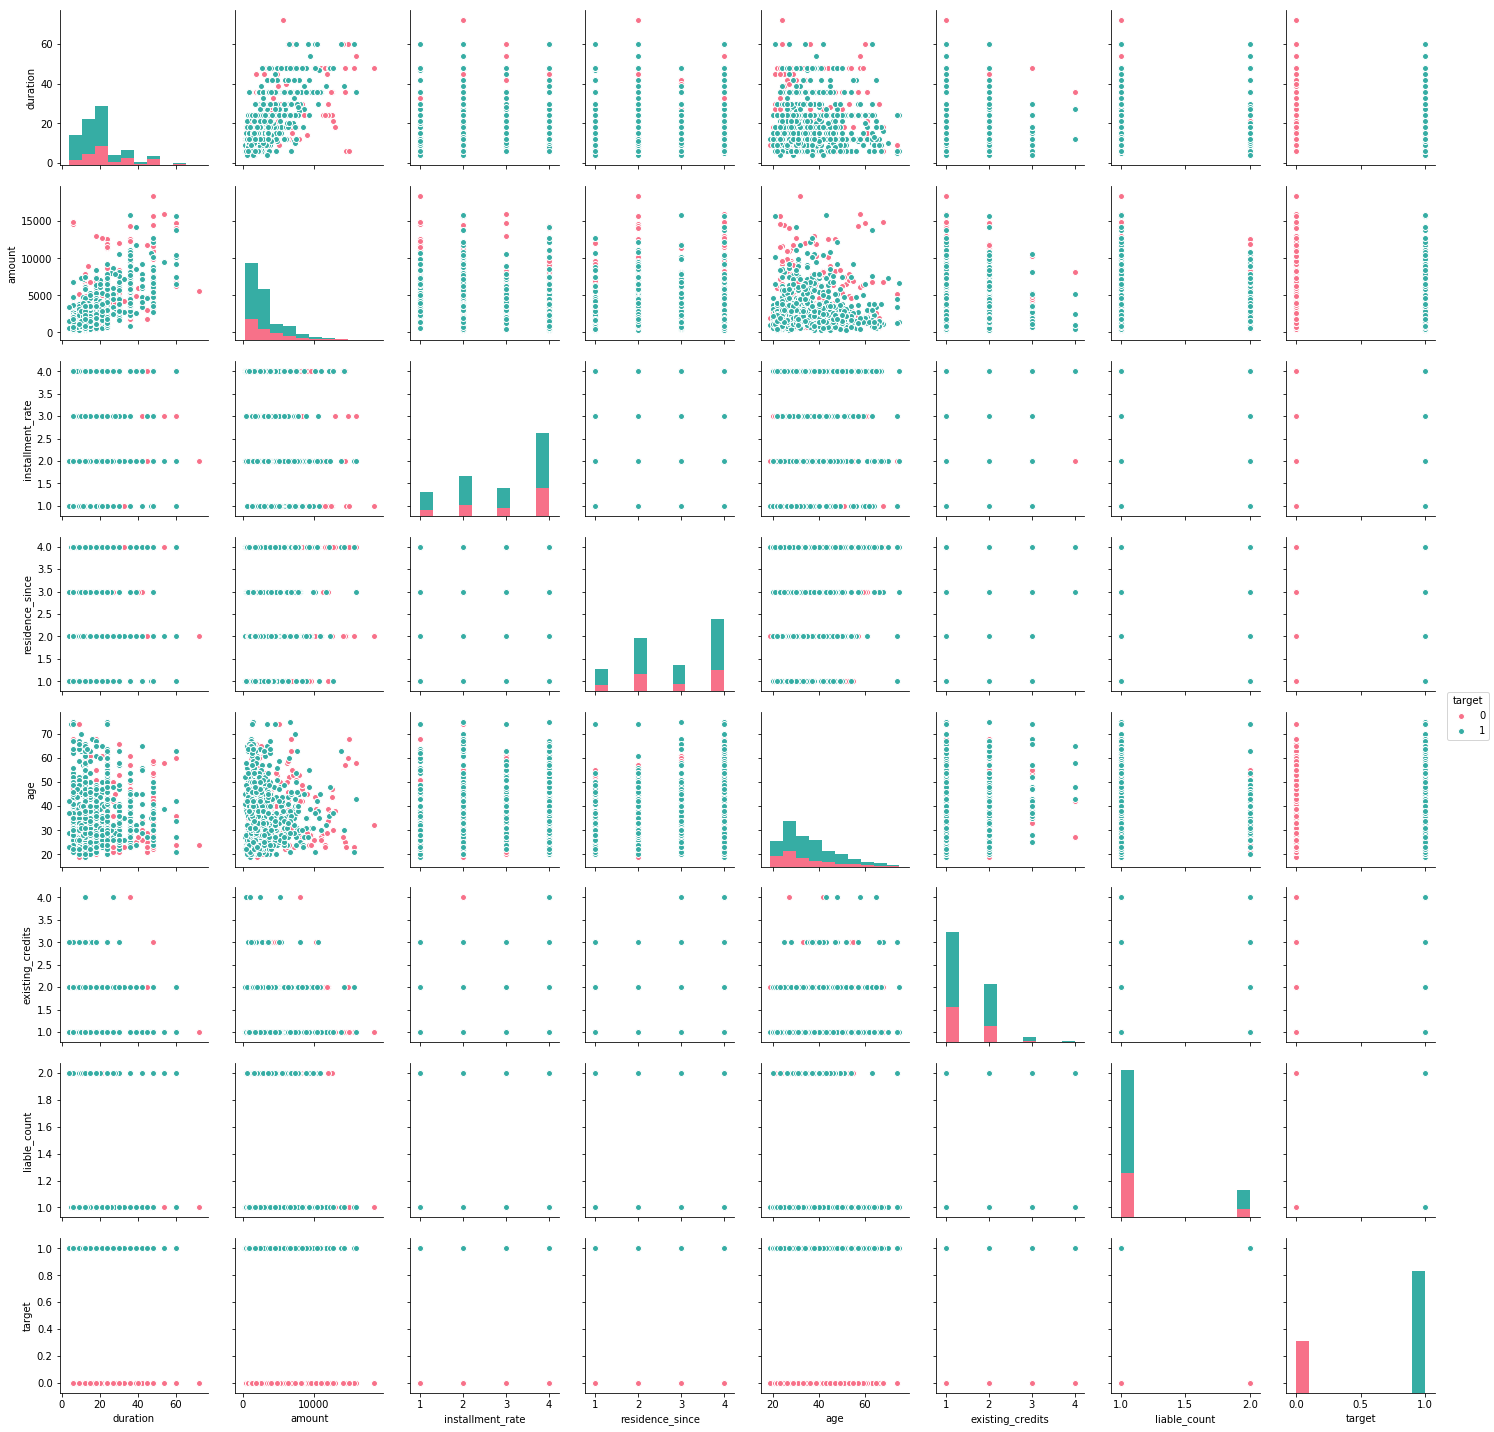

In [241]:
sns.set_palette(sns.cubehelix_palette(1))
sns.pairplot(df, hue='target');
plt.show()

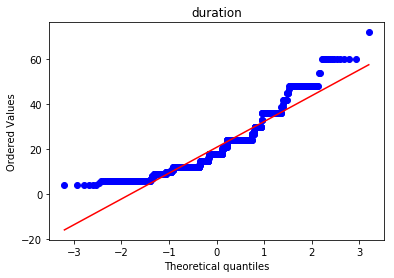

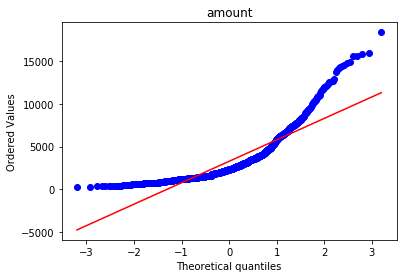

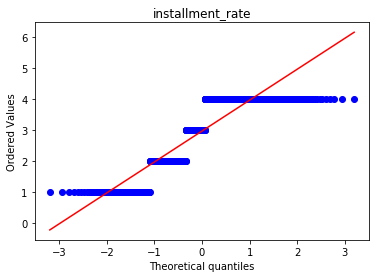

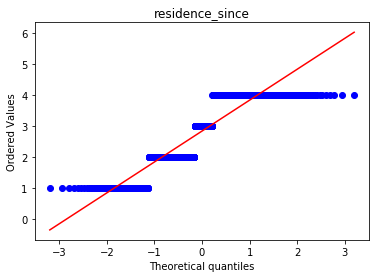

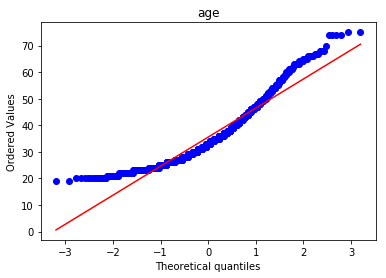

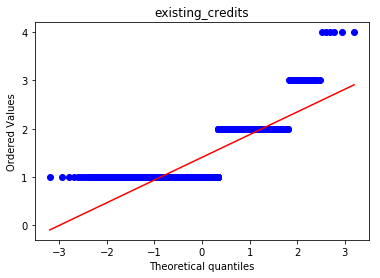

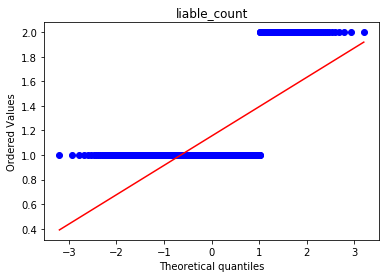

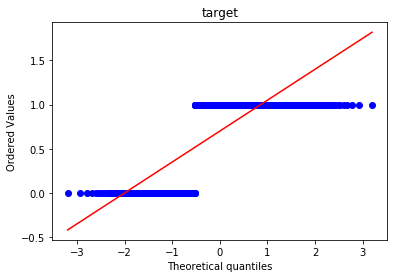

In [242]:
for i in num_cols:
    stats.probplot(df[i], dist="norm", plot=plt)
    plt.title(i)
    plt.show()

In [323]:
checking_ac = {
    'A11': 0,
    'A14': 1,
    'A12': 2,
    'A13': 3
}

saving_ac = {
    'A61': 0,
    'A64': 1,
    'A62': 2,
    'A63': 3,
    'A64': 4,
    'A65': 5
}

employment_status = {
    'A71' : 0,
    'A72' : 1,
    'A73' : 2,
    'A74' : 3,
    'A75' : 4
}

job = {
    'A171': 0,
    'A172': 1,
    'A173': 2,
    'A174': 3
}

telephone = {
    'A191': 0,
    'A192': 1
}

foreign_worker = {
    'A201': 0,
    'A202': 1
}

cat_cols = []
for col in X_train.columns:
    if len(X_train[col].unique()) < 11:
        cat_cols.append(col)
        X_train[col]=X_train[col].astype('category')

level_encoding_cols = ["checking_ac", "saving_ac", "employment_status", "installment_rate", "job", "residence_since", "liable_count", "existing_credits", 'telephone', 'foreign_worker']
one_hot_encoding_cols = list(set(cat_cols) - set(level_encoding_cols))

x_col = {'checking_ac': checking_ac, 'saving_ac': saving_ac, 'employment_status': employment_status, 'job': job, 'telephone': telephone, 'foreign_worker': foreign_worker}
for indx, val in x_col.items():
    col = indx
    rep_dict = val
    X_train[col].replace(rep_dict, inplace=True)
    X_val[col].replace(rep_dict, inplace=True)
    X_test[col].replace(rep_dict, inplace=True)
    
def one_hot_encoding(train, val, test, col_name):
    x = pd.get_dummies(train[col_name])
    y = pd.get_dummies(test[col_name])
    z = pd.get_dummies(val[col_name])
    for i in x.columns:
        train[col_name + ' is ' + i + '?'] = x[i]
        
    for i in z.columns:
        val[col_name + ' is ' + i + '?'] = z[i]
        
    for i in y.columns:
        test[col_name + ' is ' + i + '?'] = y[i]

    train.drop(col_name, axis=1, inplace=True)
    val.drop(col_name, axis=1, inplace=True)
    test.drop(col_name, axis=1, inplace=True)
    
for i in one_hot_encoding_cols:
    one_hot_encoding(X_train, X_val, X_test, i)

In [325]:
reg = LogisticRegression()
reg.fit(X_train, y_train.values.ravel())
predict = reg.predict(X_val)
acc = accurac~y_score(y_val, predict)
print("Accuracy on Validation Set: " + str(acc))
predict = reg.predict(X_test)
acc = accuracy_score(y_test, predict)
print("Accuracy on Test Set: " + str(acc))

Accuracy on Validation Set: 0.74375
Accuracy on Test Set: 0.725


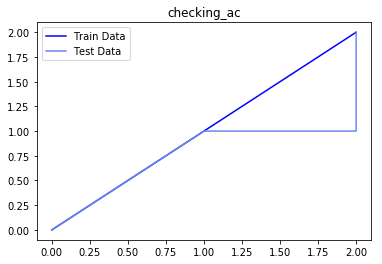

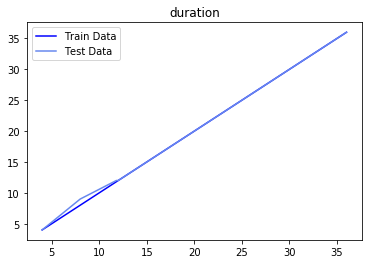

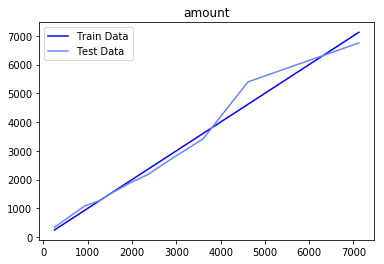

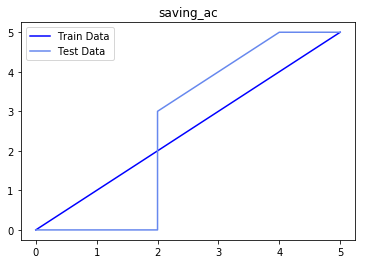

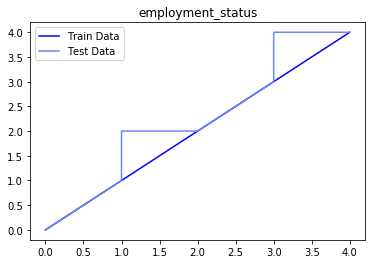

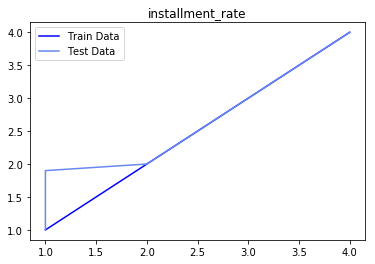

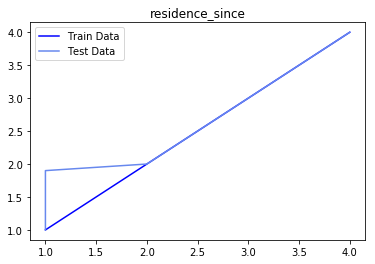

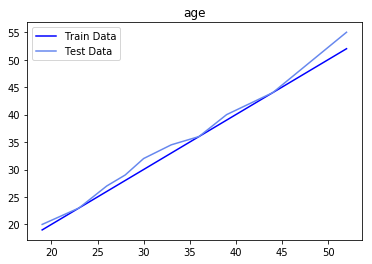

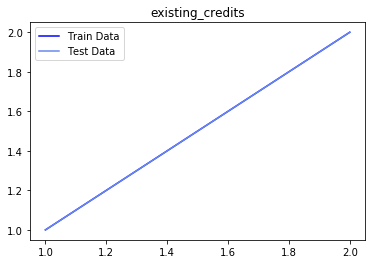

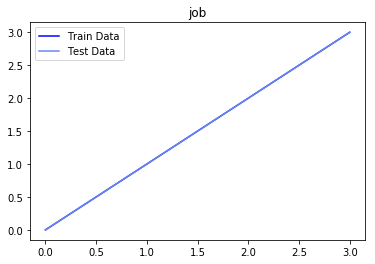

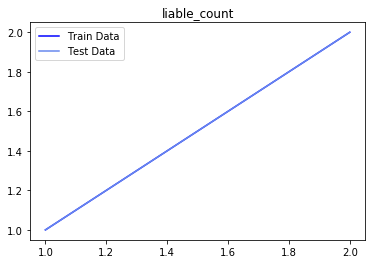

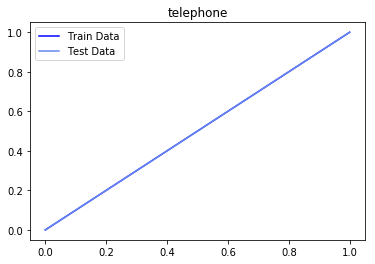

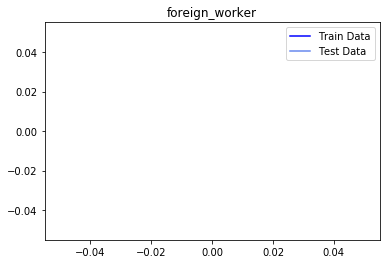

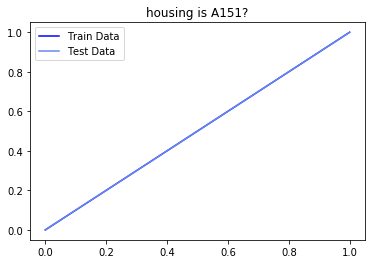

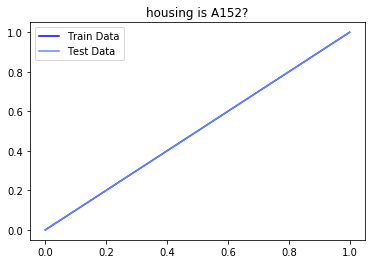

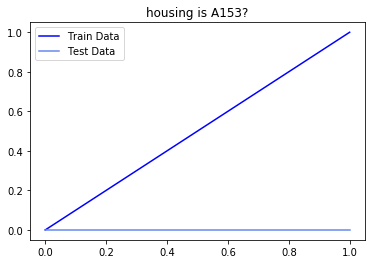

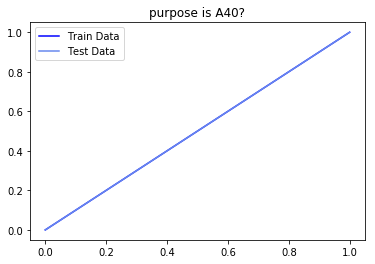

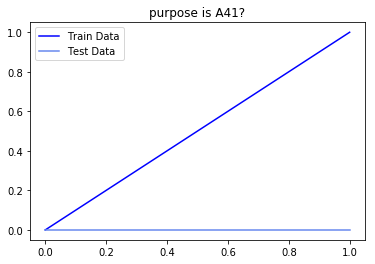

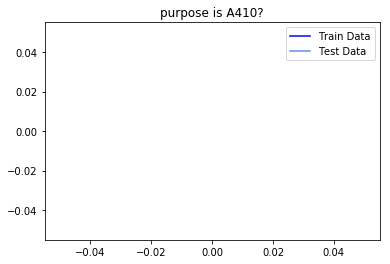

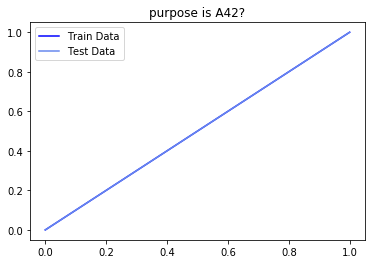

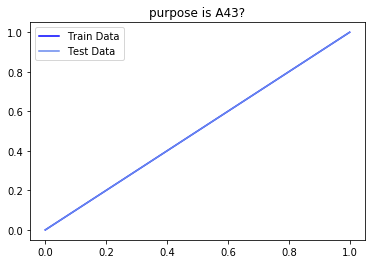

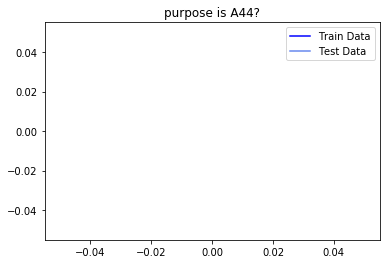

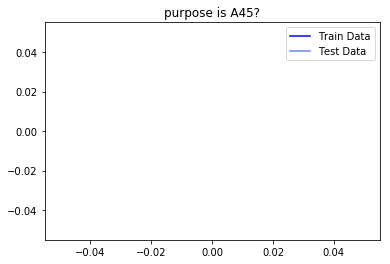

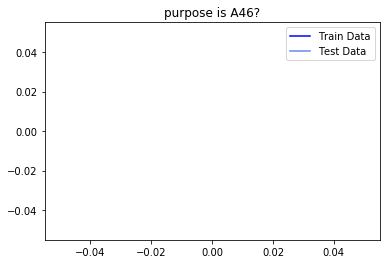

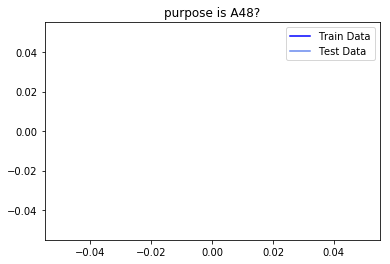

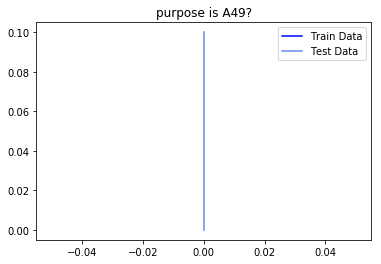

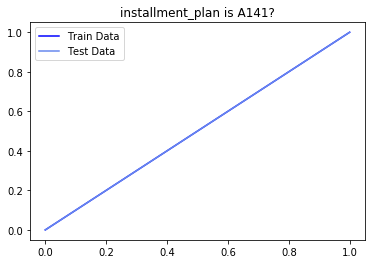

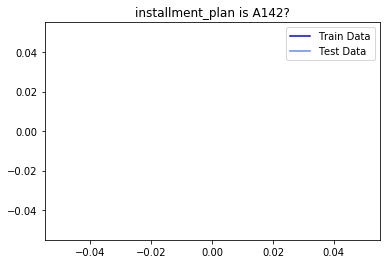

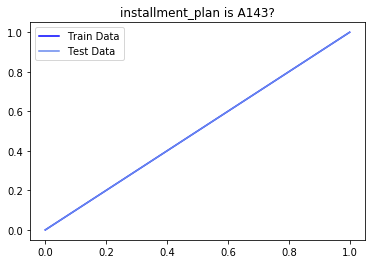

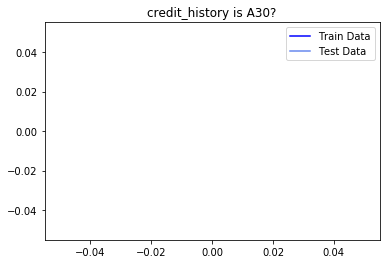

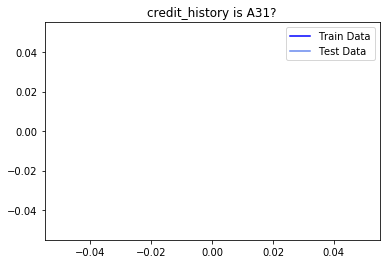

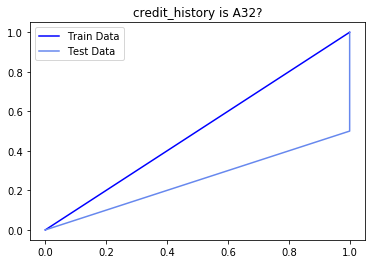

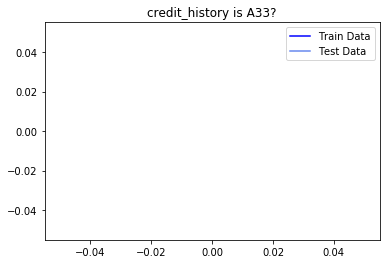

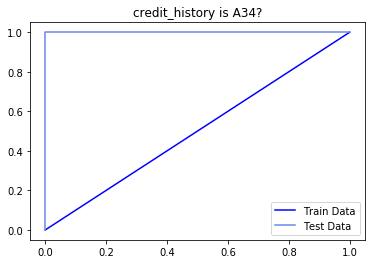

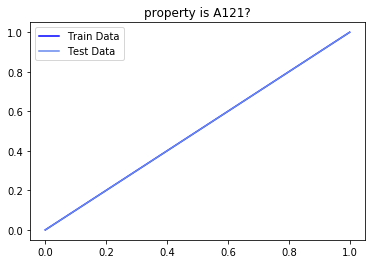

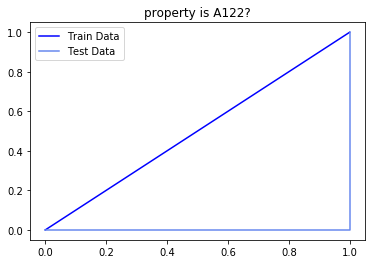

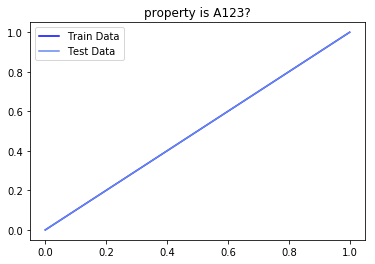

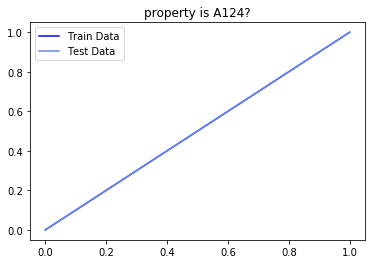

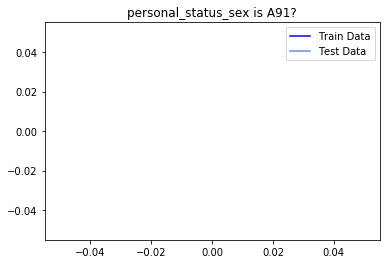

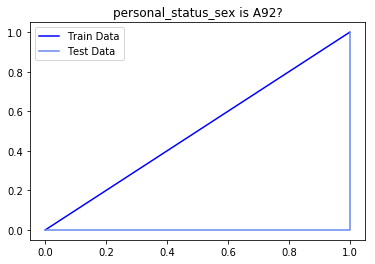

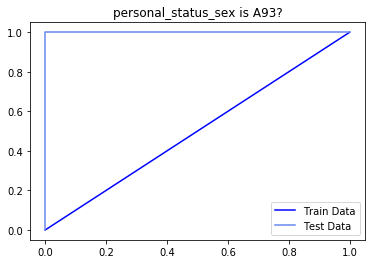

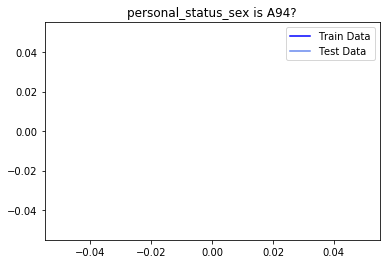

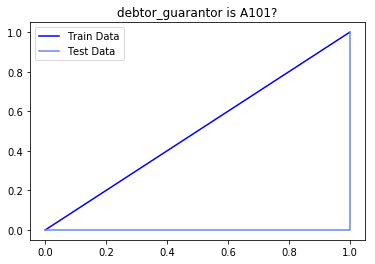

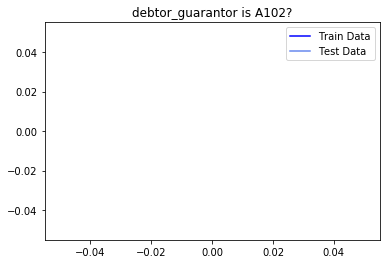

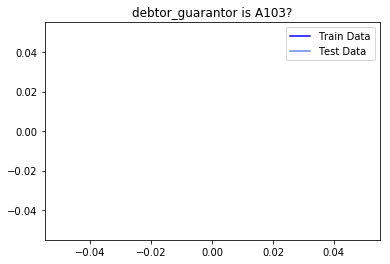

In [253]:
for val in X_train.columns:
    sns.set_palette(sns.color_palette('coolwarm'))
    q1 = X_train[val].quantile(np.arange(0.0, 1.0, 0.1))
    q2 = X_val[val].quantile(np.arange(0.0, 1.0, 0.1))
    plt.title(val)
    plt.plot(q1, q1, color='b')
    plt.plot(q1, q2)
    plt.legend(['Train Data', 'Test Data'])
    plt.show()

Outliers Count
46
Series([], Name: duration, dtype: int64)
35     45
832    45
998    45
285    47
927    48
36     48
522    48
1      48
622    48
295    48
814    48
467    48
130    48
945    48
310    48
11     48
788    48
549    48
829    48
887    48
44     48
273    48
568    48
787    48
191    48
650    48
538    48
444    48
657    48
115    48
552    48
569    48
375    48
915    48
921    48
242    48
286    48
78     54
616    60
332    60
672    60
374    60
373    60
134    60
714    60
677    72
Name: duration, dtype: int64


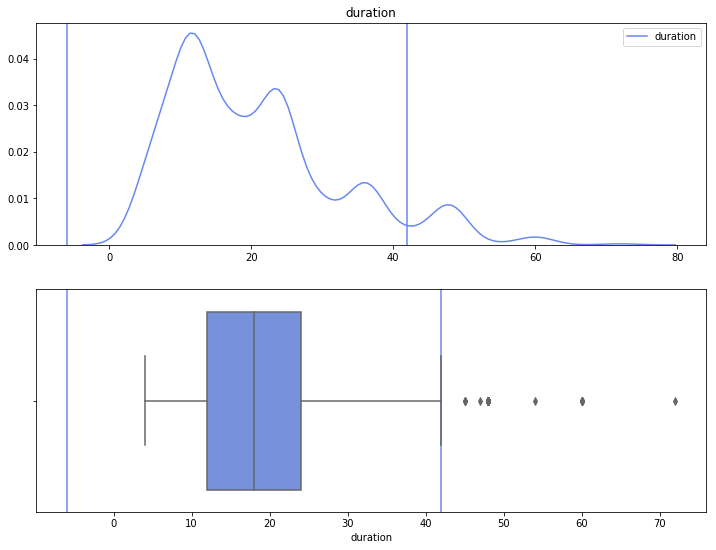

Outliers Count
49
Series([], Name: amount, dtype: int64)
889     7824
113     7855
525     7966
645     7980
17      8072
653     8086
70      8133
983     8229
491     8318
828     8335
945     8358
980     8386
417     8471
130     8487
509     8588
402     8648
549     8858
268     8978
616     9157
808     9283
291     9398
78      9436
57      9566
812     9629
684     9857
295     9960
134    10144
657    10222
927    10297
672    10366
902    10477
205    10623
285    10722
953    10974
736    11560
395    11760
832    11816
274    11998
921    12749
381    12976
373    13756
714    14027
744    14179
378    14318
236    14555
374    14782
917    14896
887    15672
915    18424
Name: amount, dtype: int64


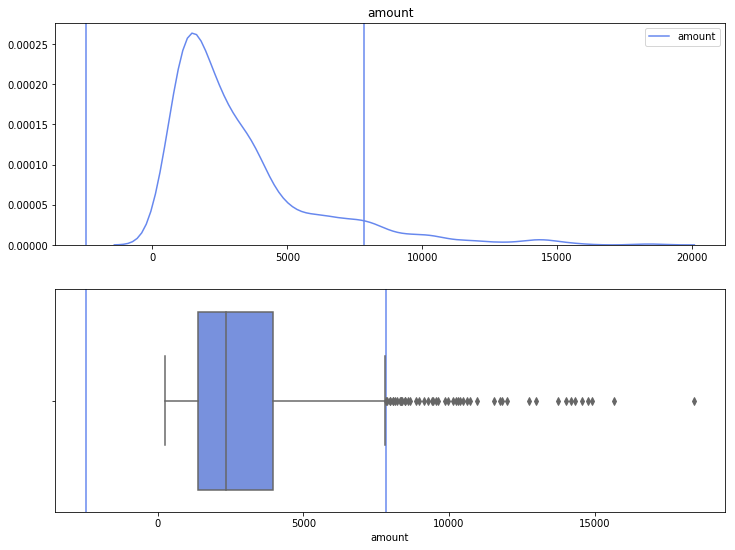

Outliers Count
15
Series([], Name: age, dtype: int64)
438    65
624    65
137    66
75     66
774    66
723    66
554    67
0      67
846    68
917    68
163    70
186    74
756    74
430    74
330    75
Name: age, dtype: int64


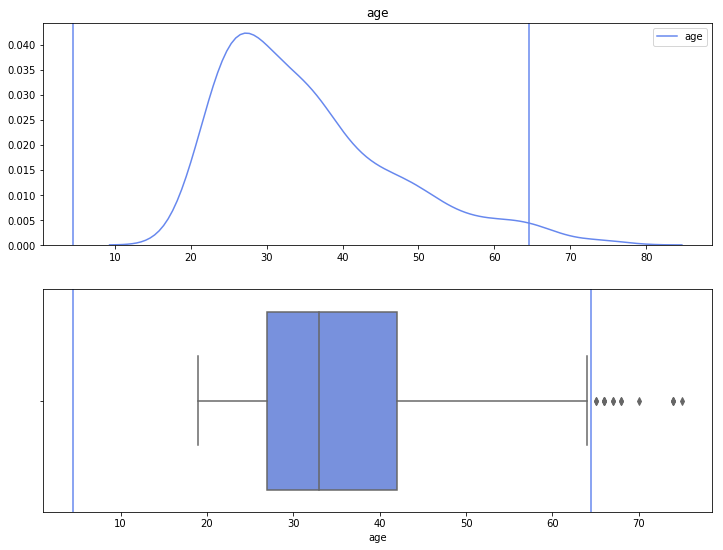

In [296]:
cat_cols = []
for col in X_train.columns:
    if len(X_train[col].unique()) < 11:
        cat_cols.append(col)
        X_train[col]=X_train[col].astype('category')

columns = X_train.columns;
num_cols = list(X_train.iloc[:, :-1]._get_numeric_data().columns)
cat_cols = list(set(columns) - set(num_cols))
# print(num_cols)

for i in num_cols:
    sns.set_palette(sns.color_palette('coolwarm'))
    q75, q25 = np.percentile(X_train[i], [75 ,25])
    iqr = q75 - q25
    min_v = q25 - (iqr*1.5)
    max_v = q75 + (iqr*1.5)
    print("Outliers Count")
    print(X_train[min_v > X_train[i]][i].count() + X_train[max_v < X_train[i]][i].count())
    print(X_train[min_v > X_train[i]][i].sort_values())
    print(X_train[max_v < X_train[i]][i].sort_values())

    fig_size = plt.rcParams["figure.figsize"]
    fig_size[0] = 12
    fig_size[1] = 9
    plt.rcParams["figure.figsize"] = fig_size
    plt.subplot(211)
    plt.title(i)
    plt.axvline(x=min_v)
    plt.axvline(x=max_v)
    ax = sns.kdeplot(X_train[i])
    plt.subplot(212)
    plt.axvline(x=min_v)
    plt.axvline(x=max_v)
    ax = sns.boxplot(X_train[i])
    plt.show()

In [298]:
def left_skew_removal(df, col_name):
    df[col_name] = np.sqrt(df[col_name])
    return df[col_name]

def right_skew_removal(df, col_name):
    df[col_name] = np.log(df[col_name])
    return df[col_name]


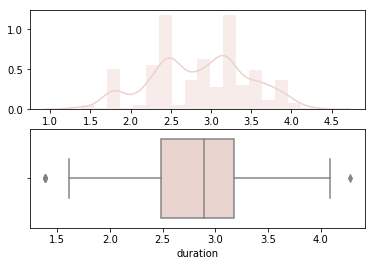

In [328]:
right_skew_removal(X_train, 'duration')
right_skew_removal(X_test, 'duration')
right_skew_removal(X_val, 'duration')

plt.subplot('211')
sns.distplot(X_train['duration'])
plt.subplot('212')
sns.boxplot(X_train['duration'])
plt.show()

# right_skew_removal(X_train, 'amount')
# right_skew_removal(X_test, 'amount')
# right_skew_removal(X_val, 'amount')

# plt.subplot('211')
# sns.distplot(X_train['amount'])
# plt.subplot('212')
# sns.boxplot(X_train['amount'])
# plt.show()

# right_skew_removal(X_train, 'age')
# right_skew_removal(X_test, 'age')
# right_skew_removal(X_val, 'age')

# plt.subplot('211')
# sns.distplot(X_train['age'])
# plt.subplot('212')
# sns.boxplot(X_train['age'])
# plt.show()

Outliers Count
6
837    1.386294
527    1.386294
234    1.386294
734    1.386294
314    1.386294
Name: duration, dtype: float64
677    4.276666
Name: duration, dtype: float64


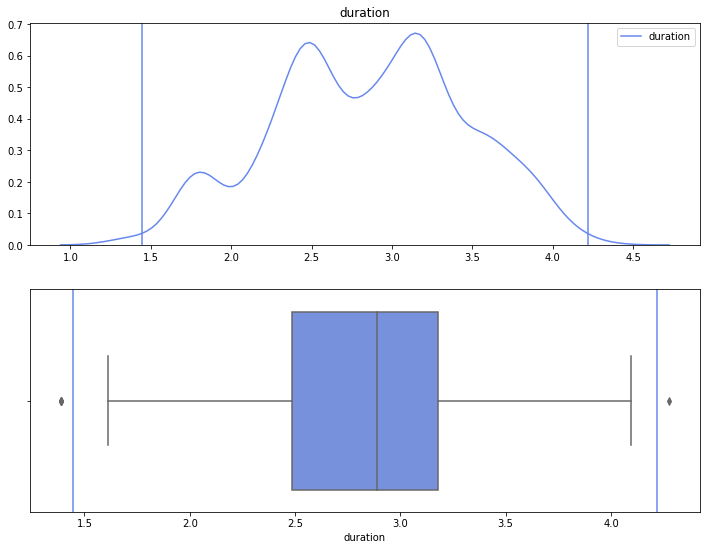

Outliers Count
2
725    5.521461
309    5.620401
Name: amount, dtype: float64
Series([], Name: amount, dtype: float64)


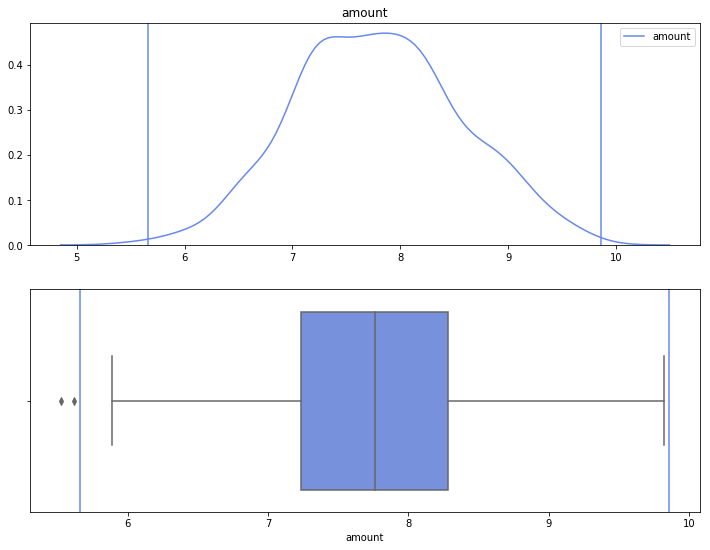

Outliers Count
0
Series([], Name: age, dtype: float64)
Series([], Name: age, dtype: float64)


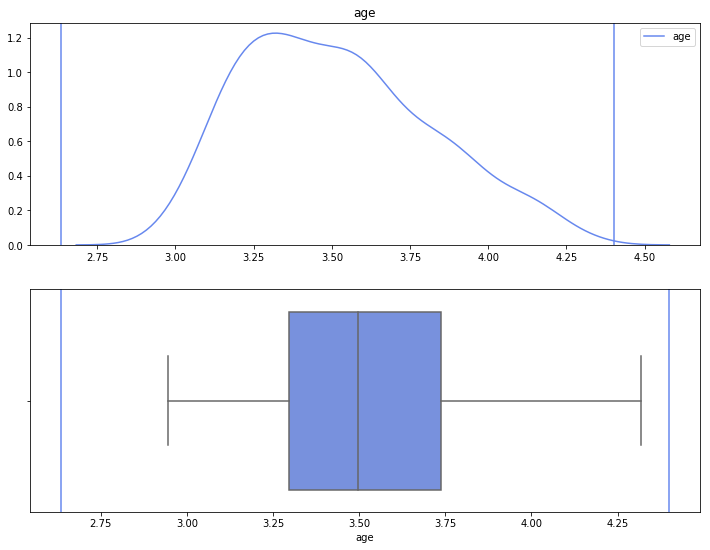

In [300]:
for i in num_cols:
    sns.set_palette(sns.color_palette('coolwarm'))
    q75, q25 = np.percentile(X_train[i], [75 ,25])
    iqr = q75 - q25
    min_v = q25 - (iqr*1.5)
    max_v = q75 + (iqr*1.5)
    print("Outliers Count")
    print(X_train[min_v > X_train[i]][i].count() + X_train[max_v < X_train[i]][i].count())
    print(X_train[min_v > X_train[i]][i].sort_values())
    print(X_train[max_v < X_train[i]][i].sort_values())

    fig_size = plt.rcParams["figure.figsize"]
    fig_size[0] = 12
    fig_size[1] = 9
    plt.rcParams["figure.figsize"] = fig_size
    plt.subplot(211)
    plt.title(i)
    plt.axvline(x=min_v)
    plt.axvline(x=max_v)
    ax = sns.kdeplot(X_train[i])
    plt.subplot(212)
    plt.axvline(x=min_v)
    plt.axvline(x=max_v)
    ax = sns.boxplot(X_train[i])
    plt.show()

/home/ubuntu/miniconda/envs/credit/lib/python3.6/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.
/home/ubuntu/miniconda/envs/credit/lib/python3.6/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':


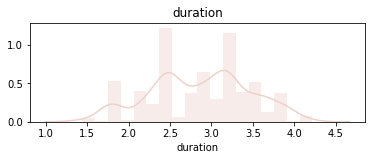

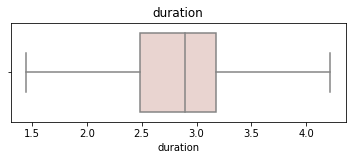

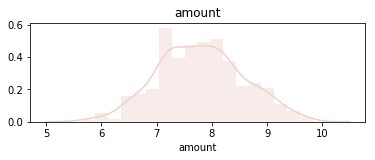

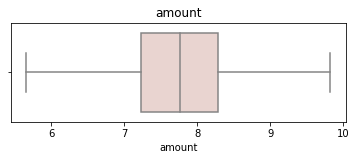

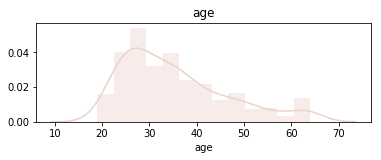

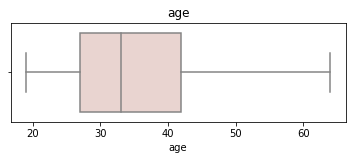

In [329]:
def remove_outlier(df, col_name):

    q75, q25 = np.percentile(df[col_name], [75 ,25])
    iqr = q75 - q25
    min_v = q25 - (iqr*1.5)
    max_v = q75 + (iqr*1.5)

    for indx, val in df[col_name].iteritems():
        if val < min_v:
            df[col_name][indx] = min_v
        elif val > max_v:
            df[col_name][indx] = max_v
            
    plt.subplot('211')
    dist_plot(df, col_name)
    plt.subplot('212')
    box_plot(df, col_name)
    plt.show()

for i in num_cols:
    remove_outlier(X_train, i)

Outliers Count
0
Series([], Name: duration, dtype: float64)
Series([], Name: duration, dtype: float64)


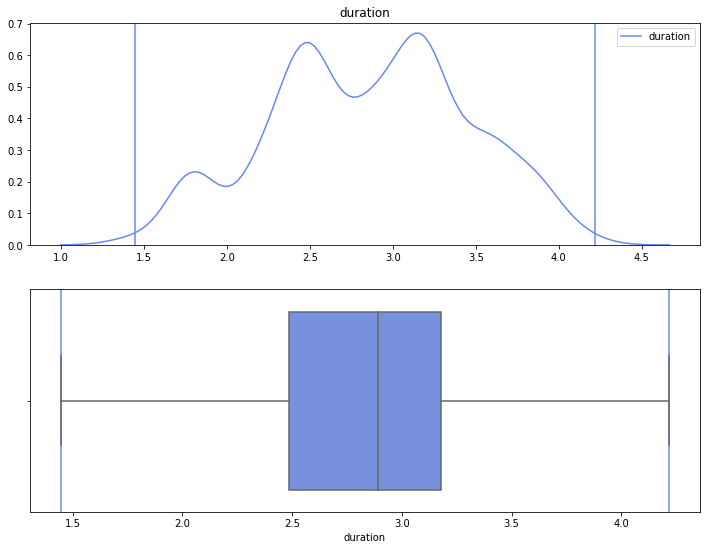

Outliers Count
0
Series([], Name: amount, dtype: float64)
Series([], Name: amount, dtype: float64)


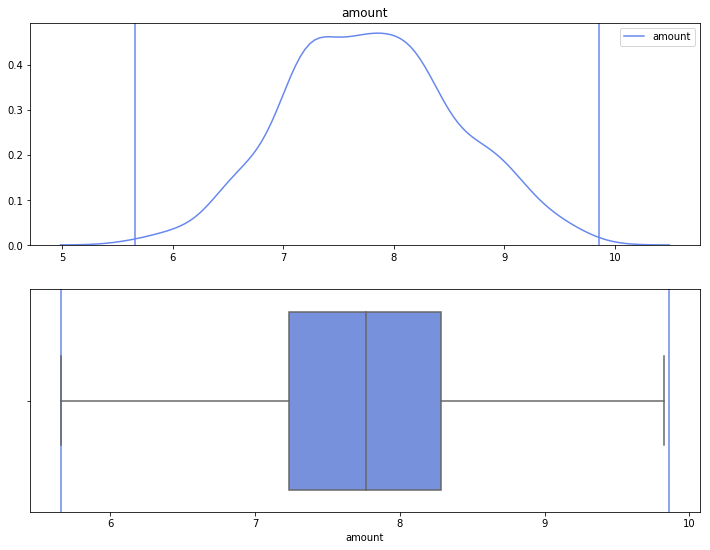

Outliers Count
0
Series([], Name: age, dtype: float64)
Series([], Name: age, dtype: float64)


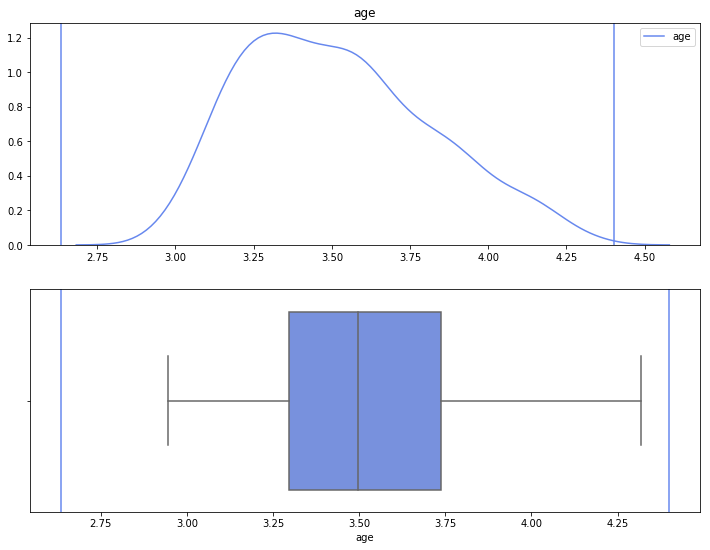

In [304]:
for i in num_cols:
    sns.set_palette(sns.color_palette('coolwarm'))
    q75, q25 = np.percentile(X_train[i], [75 ,25])
    iqr = q75 - q25
    min_v = q25 - (iqr*1.5)
    max_v = q75 + (iqr*1.5)
    print("Outliers Count")
    print(X_train[min_v > X_train[i]][i].count() + X_train[max_v < X_train[i]][i].count())
    print(X_train[min_v > X_train[i]][i].sort_values())
    print(X_train[max_v < X_train[i]][i].sort_values())

    fig_size = plt.rcParams["figure.figsize"]
    fig_size[0] = 12
    fig_size[1] = 9
    plt.rcParams["figure.figsize"] = fig_size
    plt.subplot(211)
    plt.title(i)
    plt.axvline(x=min_v)
    plt.axvline(x=max_v)
    ax = sns.kdeplot(X_train[i])
    plt.subplot(212)
    plt.axvline(x=min_v)
    plt.axvline(x=max_v)
    ax = sns.boxplot(X_train[i])
    plt.show()

In [330]:
reg = LogisticRegression()
reg.fit(X_train, y_train.values.ravel())
predict = reg.predict(X_val)
acc = accuracy_score(y_val, predict)
print("Accuracy on Validation Set: " + str(acc))
predict = reg.predict(X_test)
acc = accuracy_score(y_test, predict)
print("Accuracy on Test Set: " + str(acc))

Accuracy on Validation Set: 0.7375
Accuracy on Test Set: 0.715
